# 0. Importing packages

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import librosa
import os
import IPython.display as ipd

In [2]:
# Torch imports
import torch
import torchaudio
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchaudio.transforms import MelSpectrogram, Resample
from IPython.display import Audio
import torch.optim as optim

/Users/junichikoganemaru/miniforge3/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
SAMPLE_RATE = 32000 # All our audio uses this sample rate
SAMPLE_LENGTH = 5 # Duration we want to crop our audio to
NUM_SPECIES = 182 # Number of bird species we need to label
DATA_DIR = "data/"

# 1. Exploratory data analysis

In [4]:
train = pd.read_csv(DATA_DIR + "train_metadata.csv")
train.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'primary_label', 'secondary_labels',
       'type', 'latitude', 'longitude', 'scientific_name', 'common_name',
       'author', 'license', 'rating', 'url', 'filename', 'duration',
       'channels', 'bitrate', 'sample_rate'],
      dtype='object')

In [5]:
num_species = len(train["primary_label"].unique())

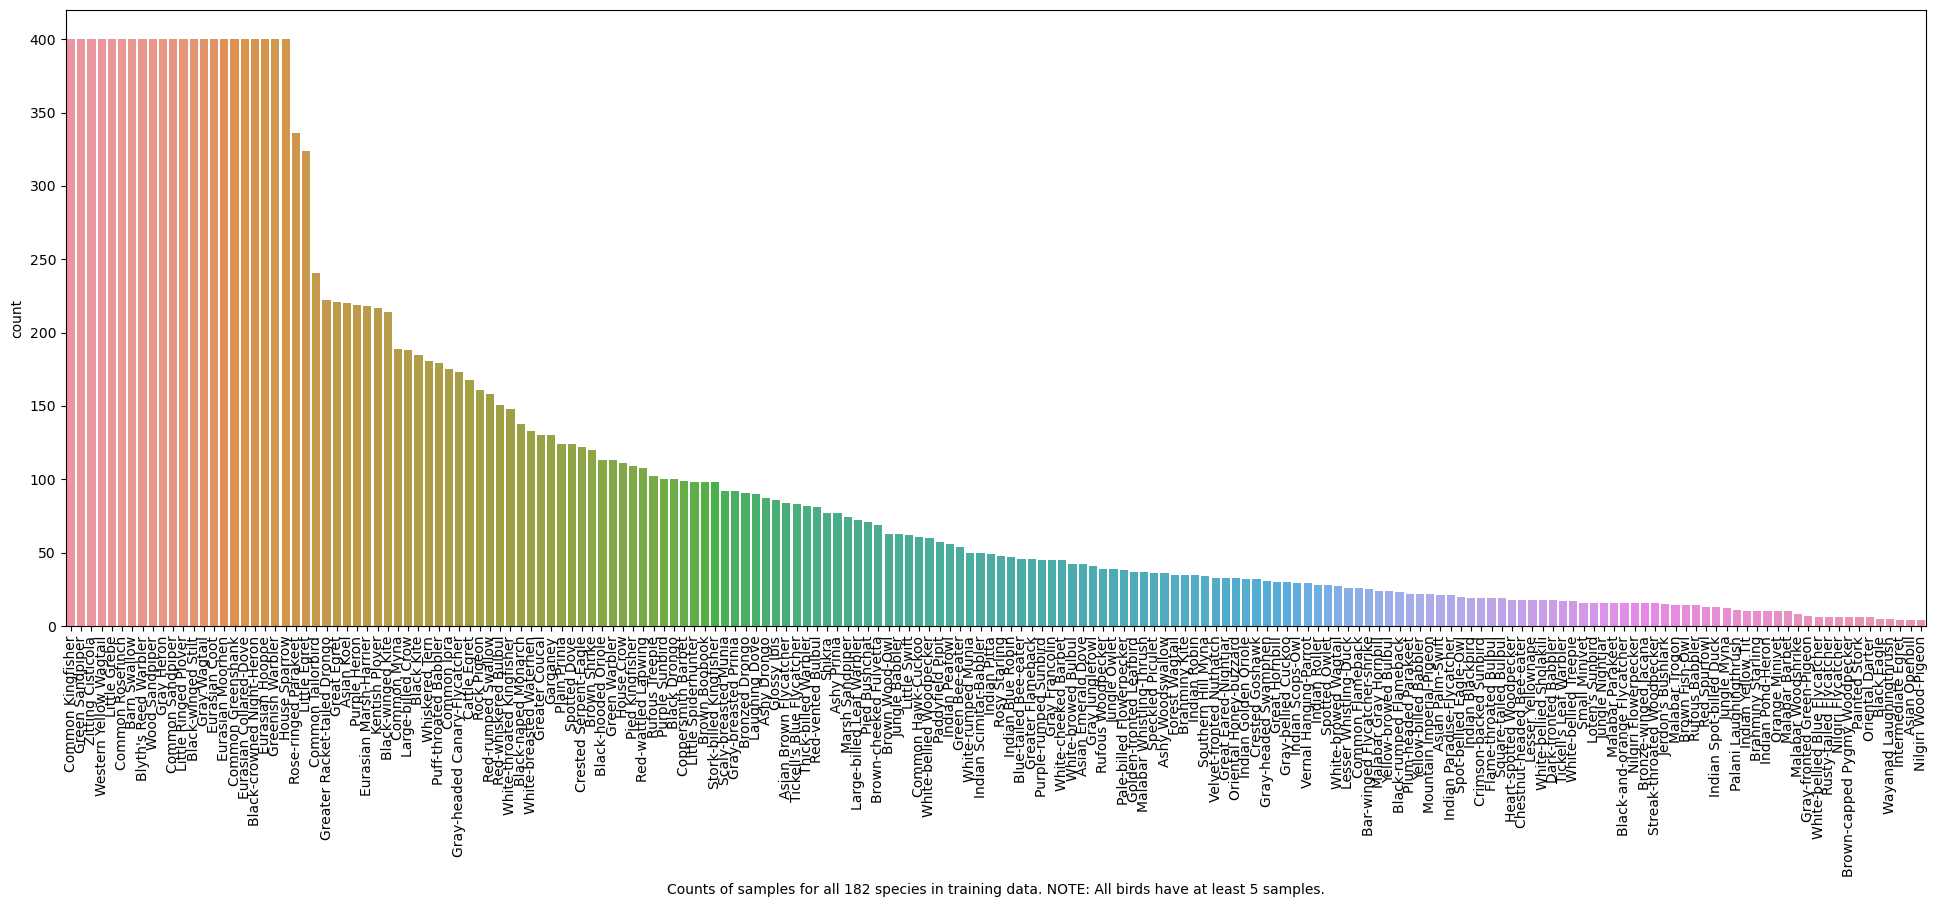

In [6]:
fig, ax = plt.subplots(figsize=(24, 8))
freqs = sns.countplot(data=train, x='common_name', ax=ax, order=train['common_name'].value_counts().index)
freqs.set_xlabel('Counts of samples for all ' + str(num_species) + ' species in training data. NOTE: All birds have at least 5 samples.')
plt.xticks(rotation=90);

There are 2319 recordings with rating at most 2.5


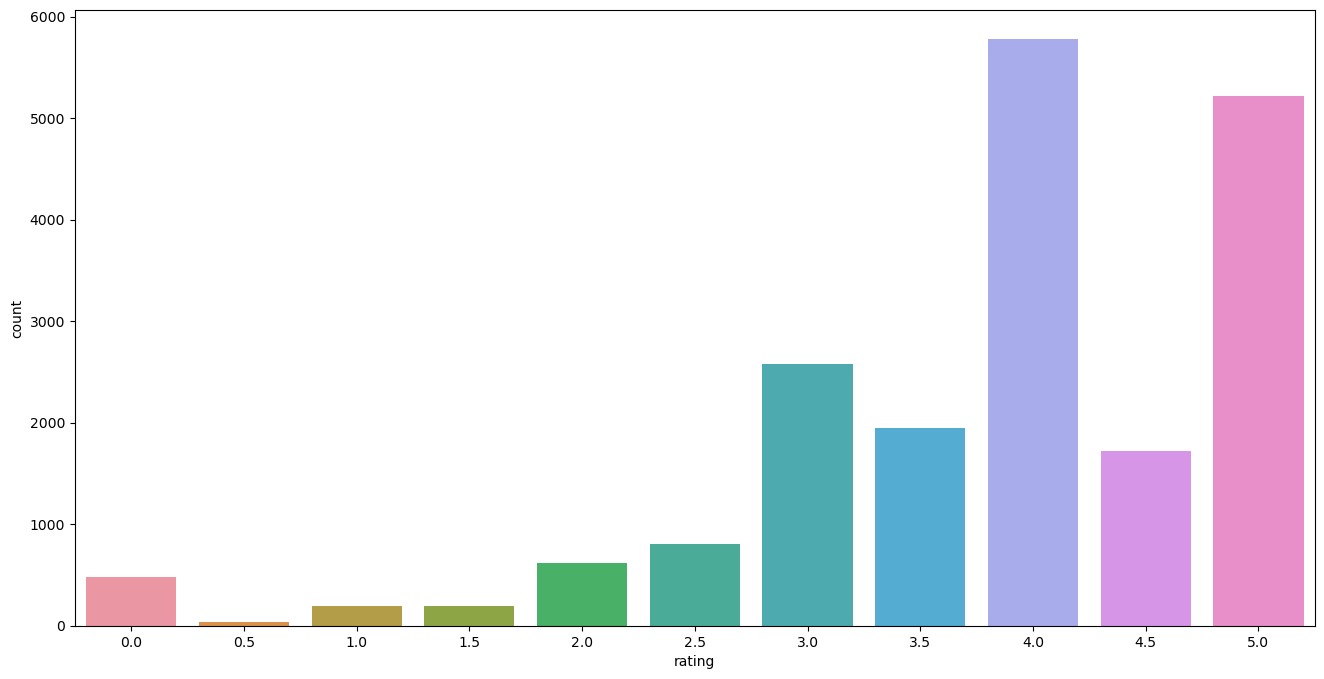

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(data=train, x='rating', ax=ax);
print("There are " + str(len(train[train["rating"] <= 2.5])) + " recordings with rating at most 2.5")

In [8]:
fig = px.scatter_geo(
    train,
    lat="latitude",
    lon="longitude",
    color="common_name",
    width=1_000,
    height=500,
    title="BirdCLEF 2024 Training Data",
)
fig.show()

In [9]:
# All our data is single channel, 72000 bitrate, 32000 sample rate. Very clean!
train[["channels","bitrate", "sample_rate"]].value_counts()

channels  bitrate  sample_rate
1         72000    32000          19567
dtype: int64

In [10]:
# For each bird type, we compute the total duration of clips we have for that species.
total_durations = train.groupby(by = "common_name")["duration"].sum().sort_values(ascending=False)

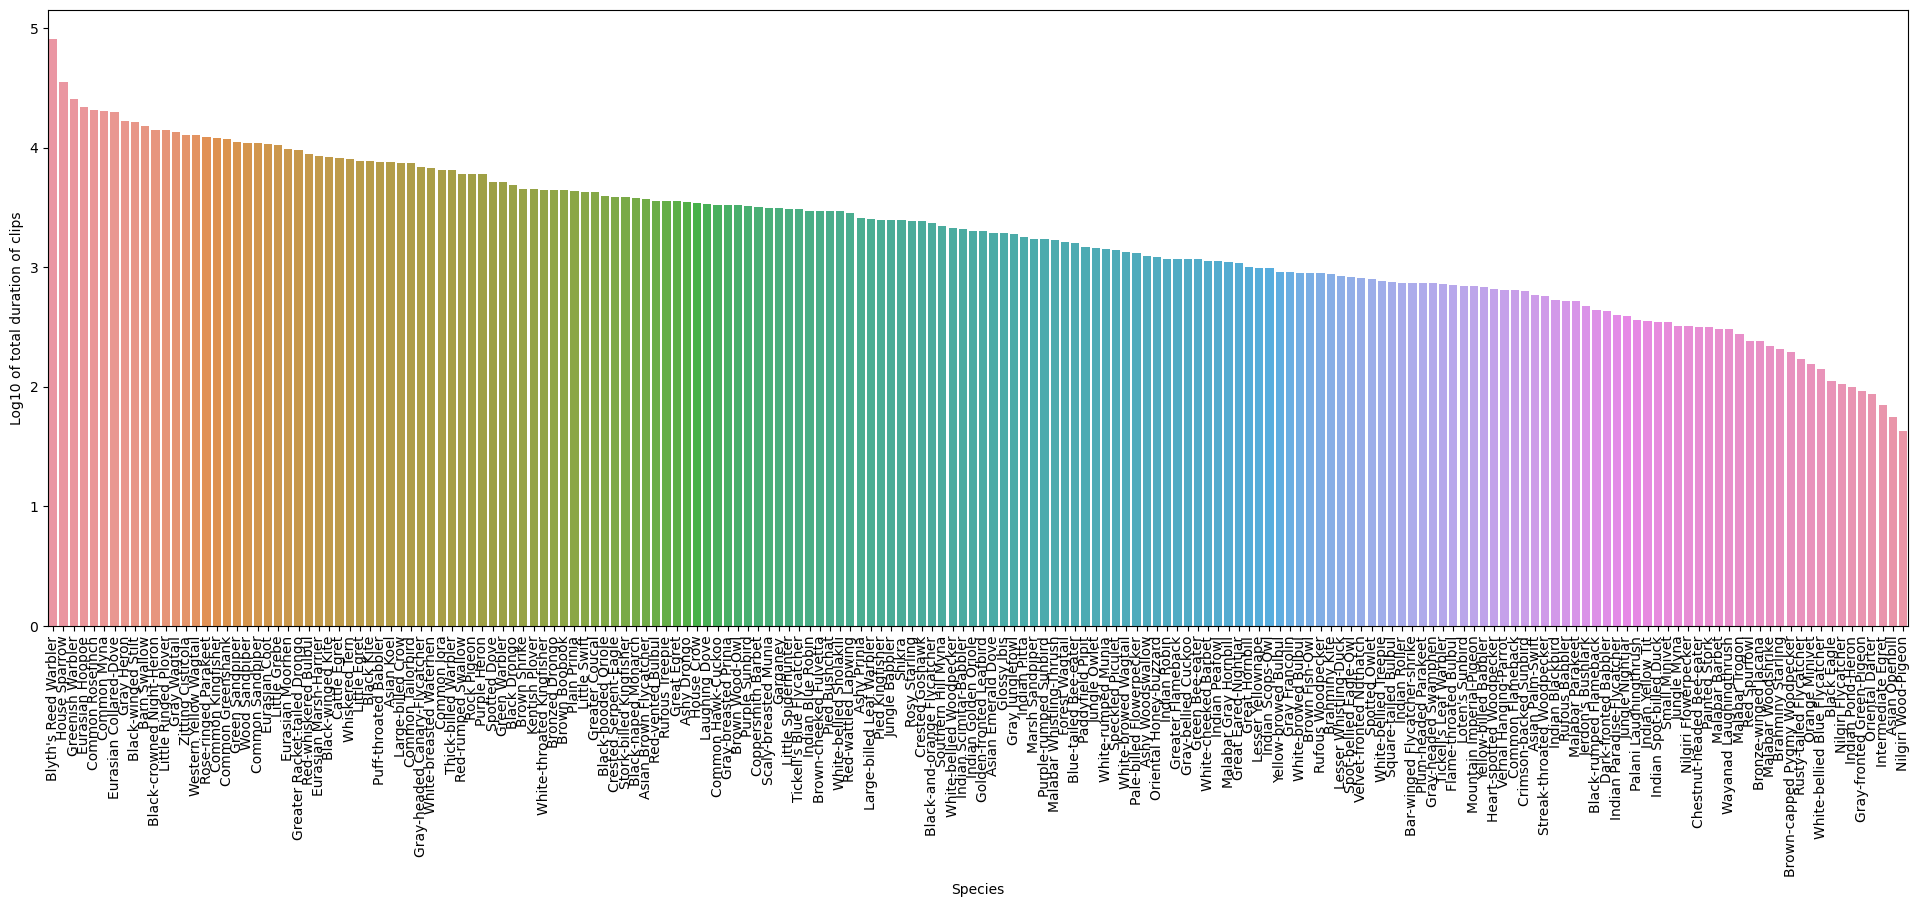

In [11]:
fig, ax = plt.subplots(figsize=(24, 8))
durations = sns.barplot(x = total_durations.index, y = np.log10(total_durations.values))
durations.set_ylabel('Log10 of total duration of clips')
durations.set_xlabel('Species')
plt.xticks(rotation=90);

In [16]:
train["duration"].describe()

count    19567.000000
mean        41.858696
std        103.145636
min          0.470000
25%         11.216375
50%         22.491437
75%         44.554000
max       5964.225000
Name: duration, dtype: float64

In [15]:
len(train [ train["duration"] < 5 ])

736

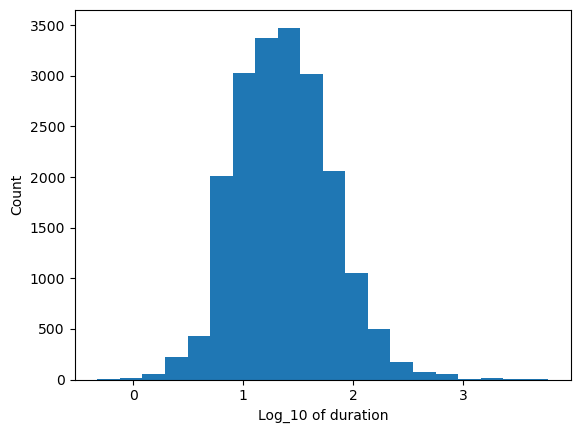

In [12]:
# Most clips are 10-100 seconds
plt.hist(np.log10(train["duration"]), bins = 20)
plt.xlabel("Log_10 of duration")
plt.ylabel("Count")
plt.show()

# 2. Preprocessing and Generating Spectrograms

In [6]:
# For cutting a sequence up into segments
from Preprocessing.preprocessing import slices

In [13]:
# Transforms audio signal to a spectrogram
spectrogram_transform = torchaudio.transforms.Spectrogram(
        n_fft=2048,
        win_length=2048,
        hop_length=512,
        power=2
    )

In [14]:
# Converts ordinary spectrogram to Mel scale
mel_spectrogram_transform = torchaudio.transforms.MelScale(
    n_mels=256,
    sample_rate=SAMPLE_RATE,
    f_min=0,
    f_max=16000,
    n_stft=1025  # the number of frequency bins in the spectrogram
)

In [15]:
# Scales decibels to reasonable level (apply to a spectrogram or Mel spectrogram)
db_scaler = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)

In [16]:
# Resizes spectrograms into square images
resize = transforms.Resize((224, 224), antialias = None)

In [17]:
# Takes a filepath and outputs a torch tensor that we can feed into our CNN
def filepath_to_tensor(filepath):
    sample, _ = torchaudio.load(filepath)
    if len(sample) >= SAMPLE_RATE * SAMPLE_LENGTH:
        sample = sample[:SAMPLE_RATE * SAMPLE_LENGTH]
    else:
        pad_length = SAMPLE_RATE * SAMPLE_LENGTH - len(sample)
        sample = torch.nn.functional.pad(sample, (0, pad_length))
    spec = spectrogram_transform(sample)
    mel_spec = mel_spectrogram_transform(spec)
    db_scaled_mel_spec = db_scaler(mel_spec)
    resized = resize(db_scaled_mel_spec)
    return resized

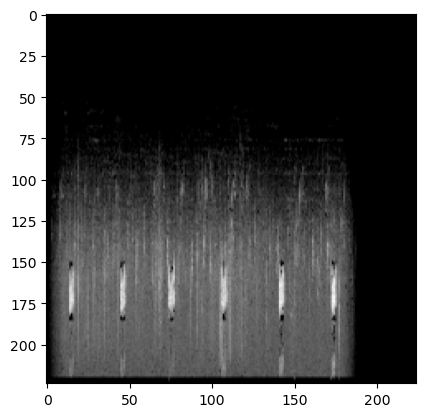

In [27]:
t = filepath_to_tensor(DATA_DIR+"train_audio/"+train.iloc[0]['filename'])
plt.imshow(t.squeeze().numpy(), cmap='gray')
plt.show()

# 3. Creating a Torch Dataset

In [19]:
class birdCLEF_dataset(Dataset):
    def __init__(self, filepaths, labels):
        super().__init__()
        self.filepaths = filepaths
        self.labels = labels

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index):
        processed_clip = filepath_to_tensor(self.filepaths[index])
        return processed_clip, self.labels[index]

In [20]:
# Create a smaller training set, using first five clips of each bird

species = train["primary_label"].unique()
small_train = {"primary_label":[], "filepath":[]}
for s in species:
    first_five = train[train["primary_label"] == s].iloc[0:5]
    small_train["primary_label"] += [s]*5
    small_train["filepath"] += first_five['filename'].apply(lambda x: DATA_DIR+"train_audio/"+x).to_list()

small_train = pd.DataFrame(small_train)
small_train.head(7)

,primary_label,filepath
0,asbfly,data/train_audio/asbfly/XC134896.ogg
1,asbfly,data/train_audio/asbfly/XC164848.ogg
2,asbfly,data/train_audio/asbfly/XC175797.ogg
3,asbfly,data/train_audio/asbfly/XC207738.ogg
4,asbfly,data/train_audio/asbfly/XC209218.ogg
5,ashdro1,data/train_audio/ashdro1/XC114598.ogg
6,ashdro1,data/train_audio/ashdro1/XC114599.ogg


In [21]:
# Create one-hot encoding for primary_label
labels_to_indices = {species[i]: i for i in range(len(species))}
one_hot_label_list = torch.nn.functional.one_hot(torch.tensor(range(len(species)), dtype = torch.long), len(species))
labels = [one_hot_label_list[labels_to_indices[s]] for s in small_train['primary_label']]

dataset = birdCLEF_dataset(filepaths = small_train['filepath'], labels = labels)

# 4. Instantiate a Torch Dataloader

In [22]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 5. Defining neural network architecture 

In [41]:
class birdClassifier(nn.Module):
    ''' Pared down architecture from https://github.com/musikalkemist/pytorchforaudio/blob/main/10%20Predictions%20with%20sound%20classifier/cnn.py'''
    def __init__(self, num_classes):
        super(birdClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=5,
                stride=2,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.dropout = nn.Dropout(p=0.1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(25088, num_classes)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

model = birdClassifier(NUM_SPECIES)

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 6. Training

In [ ]:

for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels.to(torch.float))
        loss.backward()

        # Update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {(i + 1):5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 6.114
[1,   200] loss: 5.211
[2,   100] loss: 5.017
[2,   200] loss: 4.999
[3,   100] loss: 2.864


# 7. Testing